# Predicting the Severity of a Car Accident in Seattle, Washington

# Introduction / Business Problem

Seattle, Washington, has a notorious reputation as being a wet and rainy city. As Seattle experiences an average of 152 rainy days a year(1) -- more than most North American cities -- we want to see if there is a correlation between weather and car accidents on Seattle streets. Using extensive accident data gathered from the Seattle Department of Transportation, we will predict the severity of such accidents under various weather conditions and make a determination if such factors as weather, time of day, and road condition, have an effect on the frequency of car accidents, as well as the severity of them.

The assessment and predictions to be performed here in this project shall be of interest to motorists of Seattle streets. A motorist could use these predictions and analyses to plan their travels around certain weather, road, and lighting conditions.

# Data

We will be using a data set published by the Seattle Department of Transportation (SDOT) titled "Collisions - All Years" that contains 194,673 collisions that occurred between January 1, 2004, and May 20, 2020. The collisions were provided by the Seattle Police Department and recorded by the SDOT's Traffic Records group. A sample of the data is below:

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression,  LogisticRegression
import pylab as pl
import seaborn as sns
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, jaccard_similarity_score, f1_score, log_loss
import itertools


In [2]:
# The code was removed by Watson Studio for sharing.

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [3]:
df.shape

(194673, 38)

In [4]:
dfcoll = df[['SEVERITYCODE','WEATHER','ROADCOND','LIGHTCOND']]

dfcoll.head()

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND
0,2,Overcast,Wet,Daylight
1,1,Raining,Wet,Dark - Street Lights On
2,1,Overcast,Dry,Daylight
3,1,Clear,Dry,Daylight
4,2,Raining,Wet,Daylight


## Data Methodology

For this project, we will take a closer look at the weather, road condition, and light condition to predict severity of a car accident. We have eliminated data columns we don't need from the dataset that won't assist in making a determination using these factors. In looking at the data below, one can see the number of reported accidents and the severity of them under various weather conditions. Severity Code 1 are non-injury accidents and Severity Code 2 are minor injury accidents.

We will create a test set from this data and look further into road conditions and lighting conditions for each weather type. 

In [5]:
pd.crosstab(dfcoll.WEATHER,dfcoll.SEVERITYCODE)

SEVERITYCODE,1,2
WEATHER,,
Blowing Sand/Dirt,41,15
Clear,75295,35840
Fog/Smog/Smoke,382,187
Other,716,116
Overcast,18969,8745
Partly Cloudy,2,3
Raining,21969,11176
Severe Crosswind,18,7
Sleet/Hail/Freezing Rain,85,28


In [6]:
dfcoll.dropna(axis=0,inplace=True)
dfcoll.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(189337, 4)

In [7]:
dfcoll.replace({'Other':None,'Unknown':None,'NaN':None},inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


We will delete any row with missing or incomplete values, such as those marked with "Unknown", "Other", or "NA".

In [8]:
dfcoll.dropna(axis=0,inplace=True)
dfcoll.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(169957, 4)

From the data cleanup, we see we now have 169,957 rows of accident data remaining. 24,716 rows were removed for incomplete or missing data. This amounts to 12.7% of the original dataset.

For this prediction, we will focus on the three main weather conditions detected: Clear, Raining, and Overcast. These three categories total for 168,396 records, or 99% of the data. 

Due to the smaller numbers recorded for the other weather conditions, it can be assumed that those weather conditions occur rarely and/or are open for interpretation by the officer recording the accident.

In [9]:
dfnew = dfcoll[dfcoll.WEATHER.isin(['Raining','Clear','Overcast'])]
dfnew.head()

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND
0,2,Overcast,Wet,Daylight
1,1,Raining,Wet,Dark - Street Lights On
2,1,Overcast,Dry,Daylight
3,1,Clear,Dry,Daylight
4,2,Raining,Wet,Daylight


In [10]:
dfnew.shape

(168396, 4)

In [11]:
pd.crosstab(dfnew.WEATHER,dfnew.SEVERITYCODE)

SEVERITYCODE,1,2
WEATHER,,
Clear,73243,35582
Overcast,18299,8624
Raining,21570,11078


Of the main weather conditions at the time of a car accident, 108,825 car accidents (64.6% of all accidents) occurred during clear weather, whereas only 32,648 (19.4%) occurred during rainy conditions. So the initial thoughts that rainy weather may contribute to more accidents appear to be a false asumption.

In [12]:
dfnew.dtypes

SEVERITYCODE     int64
WEATHER         object
ROADCOND        object
LIGHTCOND       object
dtype: object

We will continue to normalize the data by classifying certain lighting conditions together into two groups: Day or Night. Day will consist of all data marked as "Daylight" and "Dawn". Night will consist of all data marked as "Dusk" and all variations of "Dark".

We will also group the data under Road Conditions. "Ice", "Snow/slush", and "Standing Water" will be considered "Wet". We will omit "Sand/Mud/Dirt" and "Oil" as there are not enough records to take into consideration.

In [13]:
dfnew['LIGHTCOND'].value_counts()

Daylight                    112006
Dark - Street Lights On      45962
Dusk                          5615
Dawn                          2339
Dark - No Street Lights       1384
Dark - Street Lights Off      1082
Dark - Unknown Lighting          8
Name: LIGHTCOND, dtype: int64

In [14]:
dfnew['LIGHTCOND'] = dfnew['LIGHTCOND'].replace(['Dark - Street Lights On','Dark - No Street Lights','Dark - Street Lights Off', 'Dark - Unknown Lighting','Dusk'],'Dark')
dfnew['LIGHTCOND'] = dfnew['LIGHTCOND'].replace(['Dawn'],'Daylight')
dfnew.dropna(axis=0,inplace=True)
dfnew['LIGHTCOND'].value_counts()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org

Daylight    114345
Dark         54051
Name: LIGHTCOND, dtype: int64

In [15]:
dfnew['ROADCOND'].value_counts()

Dry               121071
Wet                45932
Ice                  867
Snow/Slush           303
Standing Water       102
Sand/Mud/Dirt         61
Oil                   60
Name: ROADCOND, dtype: int64

In [16]:
dfnew['ROADCOND'] = dfnew['ROADCOND'].replace(['Ice','Snow/Slush','Standing Water'],'Wet')
dfnew['ROADCOND'] = dfnew['ROADCOND'].replace(['Sand/Mud/Dirt','Oil'],None)

dfnew.dropna(axis=0,inplace=True)
dfnew['ROADCOND'].value_counts()


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org

Dry    121155
Wet     47241
Name: ROADCOND, dtype: int64

In [17]:
dfnew.dropna(axis=0,inplace=True)
dfnew.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND
0,2,Overcast,Wet,Daylight
1,1,Raining,Wet,Dark
2,1,Overcast,Dry,Daylight
3,1,Clear,Dry,Daylight
4,2,Raining,Wet,Daylight


We have categorized all the values and will now use these remaining values under the variables weather, road condition, and lighting condition to determine if those would be a good predictor of car accident severity. But, first, we need to convert all categorical values into a numeric representation. 

In [18]:
le = LabelEncoder()
dfnew['WEATHERCODE'] = le.fit_transform(dfnew['WEATHER']) 
dfnew['ROADCONDCODE'] = le.fit_transform(dfnew['ROADCOND'])
dfnew['LIGHTCONDCODE'] = le.fit_transform(dfnew['LIGHTCOND'])
dfnew.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND,WEATHERCODE,ROADCONDCODE,LIGHTCONDCODE
0,2,Overcast,Wet,Daylight,1,1,1
1,1,Raining,Wet,Dark,2,1,0
2,1,Overcast,Dry,Daylight,1,0,1
3,1,Clear,Dry,Daylight,0,0,1
4,2,Raining,Wet,Daylight,2,1,1


In [19]:
features = dfnew[['WEATHERCODE','ROADCONDCODE','LIGHTCONDCODE']]

X = np.asarray(features)
X[0:5]

array([[1, 1, 1],
       [2, 1, 0],
       [1, 0, 1],
       [0, 0, 1],
       [2, 1, 1]])

In [20]:
y = np.asarray(dfnew['SEVERITYCODE'])
y[0:5]


array([2, 1, 1, 1, 2])

## Data Modeling and Evaluation

We will train and test several models to see which performs the best in predicting the severity of a car accident. Let's look first at a Decision Tree for prediction.

In [21]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

print(X_trainset.shape)
print(y_trainset.shape)

print(X_testset.shape)
print(y_testset.shape)

(117877, 3)
(117877,)
(50519, 3)
(50519,)


In [22]:
dtree = DecisionTreeClassifier(criterion="entropy", max_depth = 7)


In [23]:
dtree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We will now make some predictions using the test data. Then, we will print out to compare the predicted value to the actual value. 

In [24]:
ptree = dtree.predict(X_testset)

In [25]:
print (ptree[0:5])
print (y_testset[0:5])

[1 1 1 1 1]
[1 1 1 1 2]


We will now check the accuracy of the decision tree.

In [26]:
print("The accuracy of the Decision Tree Model is: ", metrics.accuracy_score(y_testset, ptree))

The accuracy of the Decision Tree Model is:  0.6715097290128467


We will now test using Support Vector Model (SVM).

In [27]:
X_svm = X

X_svm[0:5]

array([[1, 1, 1],
       [2, 1, 0],
       [1, 0, 1],
       [0, 0, 1],
       [2, 1, 1]])

In [28]:
y_svm = y

y_svm[0:5]

array([2, 1, 1, 1, 2])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.4, random_state=4)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)



(101037, 3)
(101037,)
(67359, 3)
(67359,)


In [30]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [31]:
yhat = clf.predict(X_test)
yhat[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [32]:
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat))

Avg F1-score: 0.5391
Jaccard score: 0.6712


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Let's take a look at the accuracy of the Support Vector Model.

In [33]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
     """
     This function prints and plots the confusion matrix.
     Normalization can be applied by setting `normalize=True`.
     """
     if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
     else:
         print('Confusion matrix, without normalization')
        
     print(cm)
 
     plt.imshow(cm, interpolation='nearest', cmap=cmap)
     plt.title(title)
     plt.colorbar()
     tick_marks = np.arange(len(classes))
     plt.xticks(tick_marks, classes, rotation=45)
     plt.yticks(tick_marks, classes)
        
     fmt = '.2f' if normalize else 'd'
     thresh = cm.max() / 2.
     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
     plt.tight_layout()
     plt.ylabel('True label')
     plt.xlabel('Predicted label')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           1       0.67      1.00      0.80     45210
           2       0.00      0.00      0.00     22149

   micro avg       0.67      0.67      0.67     67359
   macro avg       0.34      0.50      0.40     67359
weighted avg       0.45      0.67      0.54     67359

Confusion matrix, without normalization
[[45210     0]
 [22149     0]]


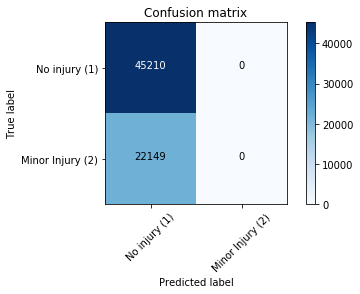

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No injury (1)','Minor Injury (2)'],normalize= False,title='Confusion matrix')


Let's now look at Logistic Regression.

In [35]:
ss = preprocessing.StandardScaler()
X_lr = X
X_lr = ss.fit(X_lr).transform(X_lr)
X_lr[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.57,  1.6 ,  0.69],
       [ 1.82,  1.6 , -1.45],
       [ 0.57, -0.62,  0.69],
       [-0.69, -0.62,  0.69],
       [ 1.82,  1.6 ,  0.69]])

In [36]:
y_lr = y_svm

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split( X_lr, y_lr, test_size=0.4, random_state=4)
print ('Logistic Regression Train set:', X_lr_train.shape, y_lr_train.shape)
print ('Logistic Regression Test set:', X_lr_test.shape, y_lr_test.shape)

Logistic Regression Train set: (101037, 3) (101037,)
Logistic Regression Test set: (67359, 3) (67359,)


In [37]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_lr_train,y_lr_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [38]:
yhat_lr = LR.predict(X_lr_test)
yhat_lr[0:10]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [39]:
yhat_lr_prob = LR.predict_proba(X_lr_test)
yhat_lr_prob[0:10]


array([[0.7 , 0.3 ],
       [0.66, 0.34],
       [0.66, 0.34],
       [0.65, 0.35],
       [0.66, 0.34],
       [0.65, 0.35],
       [0.66, 0.34],
       [0.7 , 0.3 ],
       [0.65, 0.35],
       [0.7 , 0.3 ]])

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           1       0.67      1.00      0.80     45210
           2       0.00      0.00      0.00     22149

   micro avg       0.67      0.67      0.67     67359
   macro avg       0.34      0.50      0.40     67359
weighted avg       0.45      0.67      0.54     67359

Confusion matrix, without normalization
[[45210     0]
 [22149     0]]


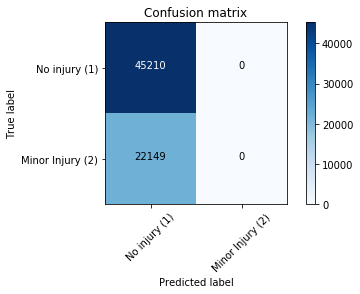

In [40]:
cnf_lr_matrix = confusion_matrix(y_lr_test, yhat_lr, labels=[1,2])
np.set_printoptions(precision=2)
print (classification_report(y_lr_test, yhat_lr))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_lr_matrix, classes=['No injury (1)','Minor Injury (2)'],normalize= False,title='Confusion matrix')

Let's attempt K-Nearest Neighbor (KNN) as another method to predicting severity.


In [41]:
X_knn = X

X_knn = preprocessing.StandardScaler().fit(X_knn).transform(X_knn.astype(float))
X_knn[0:5]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.57,  1.6 ,  0.69],
       [ 1.82,  1.6 , -1.45],
       [ 0.57, -0.62,  0.69],
       [-0.69, -0.62,  0.69],
       [ 1.82,  1.6 ,  0.69]])

In [42]:
y_knn = y
y_knn[0:10]

array([2, 1, 1, 1, 2, 1, 1, 2, 1, 2])

In [43]:
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split( X_knn, y_knn, test_size=0.4, random_state=4)
print ('KNN Train set:', X_knn_train.shape, y_knn_train.shape)
print ('KNN Test set:', X_knn_test.shape, y_knn_test.shape)


KNN Train set: (101037, 3) (101037,)
KNN Test set: (67359, 3) (67359,)


In [44]:
from sklearn.neighbors import KNeighborsClassifier

We'll test different numbers of nearest neighbors to examine the accuracy of the model and we'll plot the model accuracy.

In [45]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):

 #Train Model and Predict
 neigh = KNeighborsClassifier(n_neighbors = n).fit(X_knn_train,y_knn_train)
 yhat_knn=neigh.predict(X_knn_test)
 mean_acc[n-1] = metrics.accuracy_score(y_knn_test, yhat_knn)

 std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat_knn.shape[0])
mean_acc

array([0.57, 0.64, 0.63, 0.64, 0.62, 0.62, 0.62, 0.64, 0.63])

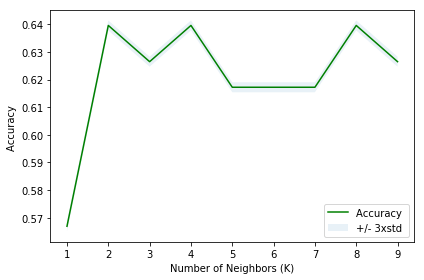

In [46]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

We learn that where K = 2, 4 or 8, we have the highest accuracy at 64% of the time.

In [47]:
k = 4
#Train Model and Predict
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_knn_train,y_knn_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

## Data Results

Let's take a look at different metrics for each model to see which reports the highest accuracy.

In [50]:
knn_yhat = kNN_model.predict(X_knn_test)
print("KNN Jaccard index: %.4f" % jaccard_similarity_score(y_knn_test, knn_yhat))
print("KNN F1-score: %.4f" % f1_score(y_knn_test, knn_yhat, average='weighted') )


KNN Jaccard index: 0.6396
KNN F1-score: 0.5714


In [51]:
DT_yhat = dtree.predict(X_testset)
print("DT Jaccard index: %.4f" % jaccard_similarity_score(y_testset, DT_yhat))
print("DT F1-score: %.4f" % f1_score(y_testset, DT_yhat, average='weighted') )


DT Jaccard index: 0.6715
DT F1-score: 0.5395


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
SVM_yhat =clf.predict(X_test)
print("SVM Jaccard index: %.4f" % jaccard_similarity_score(y_test, SVM_yhat))
print("SVM F1-score: %.4f" % f1_score(y_test, SVM_yhat, average='weighted') )


SVM Jaccard index: 0.6712
SVM F1-score: 0.5391


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
LR_yhat = LR.predict(X_lr_test)
LR_yhat_prob = LR.predict_proba(X_lr_test)
print("LR Jaccard index: %.4f" % jaccard_similarity_score(y_lr_test, LR_yhat))
print("LR F1-score: %.4f" % f1_score(y_lr_test, LR_yhat, average='weighted') )
print("LR LogLoss: %.4f" % log_loss(y_lr_test, LR_yhat_prob))

LR Jaccard index: 0.6712
LR F1-score: 0.5391
LR LogLoss: 0.6328


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The results of accuracy are as follows:


|Algorithm | Jaccard | F1-score | LogLoss |
|----------|---------|----------|---------|
|KNN | 0.6396 | 0.5714 | N/A |
|Decision Tree | 0.6715 | 0.5395 | N/A |
|SVM | 0.6712 | 0.5391 | N/A |
|Logistic Regression | 0.6712 | 0.5391 | 0.6328 |

## Further Discussion of Results

Based on our modeling, we were only able to predict the severity of car accidents accurately up to 67% of the time using either Decision Tree, Support Vector Model, or Logistic Regression. Based on the analysis we completed, the current weather, road conditions, and lighting conditions don't successfully determine the severity of the car accidents. However, we could consider for future analysis a look at other data fields provided, such as location or speeding, to determine if severity can be predicted using that.

## Conclusion

Regardless of the outcome of the findings here, 100% of recorded car accidents in the city of Seattle resulted in either no injuries (1) or very minor injuries (2). No accidents with substantial injuries or fatalities were recorded. 

We also know based on the initial data prior to processing, that more accidents occur during clear weather conditions than in conditions where precipitation is falling. In fact, almost 64.6% of all car accidents in the 16-year period of data occurred during clear weather compared to 19.4% of all accidents occurred during rainy weather. The likelihood of getting into an accident on a clear day in Seattle is 3.3 times greater than that on a rainy day.

So, with that said and for any time you get behind the wheel, whether it is a sunny day or a rainy day, always drive safe, obey the speed limit, and keep your distance between other vehicles and pedestrians to minimize your risk of getting into a car accident. 

Thank you for your time.

# Sources

1. "Seattle's Rainy Reputation Is Well-Deserved", The Weather Channel, October 14, 2016; https://weather.com/science/weather-explainers/news/seattle-rainy-reputation